## Import

In [76]:
import pandas as pd 
from sklearn.ensemble import RandomForestRegressor   
from sklearn import metrics   
from sklearn.model_selection import train_test_split  
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
import re 
import geocoder
import requests
from bs4 import BeautifulSoup as bs
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from sklearn.preprocessing import OrdinalEncoder
import sklearn.preprocessing as preprocessing
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Игорь\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [77]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

RANDOM_SEED = 42
!pip freeze > requirements.txt

## 1. Task

Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

Первоначальная версия датасета содержит 17 полей со следующей информацией:

- hotel_address — адрес отеля;
- review_date — дата, когда рецензент разместил соответствующий отзыв;
- average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- hotel_name — название отеля;
- reviewer_nationality — страна рецензента;
- negative_review — отрицательный отзыв, который рецензент дал отелю;
- review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
- positive_review — положительный отзыв, который рецензент дал отелю;
- review_total_positive_word_counts — общее количество слов в положительном отзыве.
- reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
- total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
- total_number_of_reviews — общее количество действительных отзывов об отеле;
- tags — теги, которые рецензент дал отелю;
- days_since_review — количество дней между датой проверки и датой очистки;
- additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- lat — географическая широта отеля;
- lng — географическая долгота отеля.

In [78]:
DATA_DIR = 'C:/Users/Игорь/dst-4/PROJECT-3/'
df_train = pd.read_csv(DATA_DIR+'hotels_train.csv')
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv')
sample_submission = pd.read_csv(DATA_DIR+'submission.csv')
df_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [79]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [80]:
# Загружаем данные по индексу Джини
gdp = pd.read_excel(DATA_DIR+'API_NY.GDP.MKTP.CN_DS2_en_excel_v2_4028563.xls',header=3)

cols_to_drop = list(gdp.columns)
cols_to_drop.remove('2020')
gdp.index = gdp['Country Name']
gdp.drop(cols_to_drop,axis=1,inplace=True)
gdp = gdp.to_dict(orient='index')

gdp

{'Aruba': {'2020': nan},
 'Africa Eastern and Southern': {'2020': nan},
 'Afghanistan': {'2020': 1547289027600.0},
 'Africa Western and Central': {'2020': nan},
 'Angola': {'2020': 33756422000000.0},
 'Albania': {'2020': 1617540920000.0},
 'Andorra': {'2020': 2507800000.0},
 'Arab World': {'2020': nan},
 'United Arab Emirates': {'2020': 1317945540104.91},
 'Argentina': {'2020': 27481439972800.0},
 'Armenia': {'2020': 6181664100000.0},
 'American Samoa': {'2020': 709000000.0},
 'Antigua and Barbuda': {'2020': 3699760000.0},
 'Australia': {'2020': 1980866000000.0},
 'Austria': {'2020': 379320560000.0},
 'Azerbaijan': {'2020': 72432200000.0},
 'Burundi': {'2020': 6239579000000.0},
 'Belgium': {'2020': 456892900000.0},
 'Benin': {'2020': 9008810371200.0},
 'Burkina Faso': {'2020': 10322332746400.0},
 'Bangladesh': {'2020': 27393324000000.0},
 'Bulgaria': {'2020': 119951087000.0},
 'Bahrain': {'2020': 13058190000.0},
 'Bahamas, The': {'2020': 9907500000.0},
 'Bosnia and Herzegovina': {'2020

In [81]:
# Найдем данные об индексе Джини и населению стран
url = 'https://worldpopulationreview.com/country-rankings/gini-coefficient-by-country'
page = requests.get(url)

soup = bs(page.content, 'html.parser')
tbl = soup.find("table")

gini_index = pd.read_html(str(tbl))[0]

gini_index

,Country,Gini % - World Bank,Data Year (World Bank),Gini % - CIA World Factbook,Data Year (CIA),2022 Population
0,South Africa,63.0,2014.0,63.0,2014.0,60756135
1,Namibia,59.1,2015.0,59.1,2015.0,2633874
2,Suriname,57.9,1999.0,NaN,NaN,596831
3,Zambia,57.1,2015.0,57.1,2015.0,19470234
4,Sao Tome And Principe,56.3,2017.0,56.3,2017.0,227679
...,...,...,...,...,...,...
171,Hong Kong,NaN,NaN,53.9,2016.0,7604299
172,Cambodia,NaN,NaN,37.9,2008.0,17168639
173,Taiwan,NaN,NaN,33.6,2014.0,23888595
174,Saudi Arabia,NaN,NaN,45.9,2013.0,35844909


In [82]:
# Отделим лишнее и преобразуем в словарь для быстрого доступа
gini_index.index = gini_index['Country']
gini_index.drop(['Country','Data Year (World Bank)','Gini % - CIA World Factbook','Data Year (CIA)'],axis=1,inplace=True)
gini_index = gini_index.to_dict(orient='index')

gini_index

{'South Africa': {'Gini % - World Bank': 63.0, '2022 Population': 60756135},
 'Namibia': {'Gini % - World Bank': 59.1, '2022 Population': 2633874},
 'Suriname': {'Gini % - World Bank': 57.9, '2022 Population': 596831},
 'Zambia': {'Gini % - World Bank': 57.1, '2022 Population': 19470234},
 'Sao Tome And Principe': {'Gini % - World Bank': 56.3,
  '2022 Population': 227679},
 'Central African Republic': {'Gini % - World Bank': 56.2,
  '2022 Population': 5016678},
 'Eswatini': {'Gini % - World Bank': 54.6, '2022 Population': 1184817},
 'Mozambique': {'Gini % - World Bank': 54.0, '2022 Population': 33089461},
 'Brazil': {'Gini % - World Bank': 53.4, '2022 Population': 215353593},
 'Belize': {'Gini % - World Bank': 53.3, '2022 Population': 412190},
 'Botswana': {'Gini % - World Bank': 53.3, '2022 Population': 2441162},
 'Angola': {'Gini % - World Bank': 51.3, '2022 Population': 35027343},
 'Colombia': {'Gini % - World Bank': 51.3, '2022 Population': 51512762},
 'Saint Lucia': {'Gini % - Wor

## EDA

## 2. Duplicates and text analysis

In [83]:
# Убираем повторяющиеся
df_train.drop_duplicates(inplace=True,ignore_index=True)

In [84]:
df_train['sample'] = 1
df_train['id'] = df_train.index
df_test['sample'] = 0
df_test['reviewer_score'] = 0
df_test['id'] = df_test.index
df = df_train.copy()
df = pd.concat([df_train,df_test],axis=0,ignore_index=True)

df.shape

(515431, 19)

In [85]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386496 entries, 0 to 386495
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386496 non-null  object 
 1   additional_number_of_scoring                386496 non-null  int64  
 2   review_date                                 386496 non-null  object 
 3   average_score                               386496 non-null  float64
 4   hotel_name                                  386496 non-null  object 
 5   reviewer_nationality                        386496 non-null  object 
 6   negative_review                             386496 non-null  object 
 7   review_total_negative_word_counts           386496 non-null  int64  
 8   total_number_of_reviews                     386496 non-null  int64  
 9   positive_review                             386496 non-null  object 
 

In [87]:
data = df

# Получим список адресов отелей с координатами
h_df = data[['hotel_address','lat','lng']].groupby(by=['hotel_address'],as_index=True).mean()

# Доопределим координаты отоелей

for i in h_df[h_df['lat'].isnull()].index:
    g = geocoder.arcgis(i) 
    h_df.at[i,'lat'] = g.latlng[0]
    h_df.at[i,'lng'] = g.latlng[1]

# Разберем адрес на страну и город
h_df['country'] = ''
    
h_df['addres'] = h_df.index
h_df['country'] = h_df['addres'].apply(lambda x: x.split(' ')[-1] if (x.split(' ')[-1] != 'Kingdom') else (x.split(' ')[-2]+' '+x.split(' ')[-1]))

# Преобразуем в словарь для удобства доступа
latlng_dict = h_df.to_dict(orient='index')
    
# Определим входящие в сеть отели
data['hotel_net'] = data['hotel_name'].apply(
lambda x: re.search(r'Mercure|Golden Tulip|Holiday Inn|Golden Tulip|Radisson|Best Western|DoubleTree',x)[0] \
    if (re.search(r'Mercure|Golden Tulip|Holiday Inn|Golden Tulip|Radisson|Best Western|DoubleTree',x) is not None) \
else 'Not_in_net'
)
    
data['country'] = ''
data['country'] = data['hotel_address'].apply(lambda x: x.split(' ')[-1] if (x.split(' ')[-1] != 'Kingdom') else (x.split(' ')[-2]+' '+x.split(' ')[-1]))

# Получим данные из закаченных источников по индексу Джини, популяции и ВВП для стран с отелем
data['hc_gini'] = data['country'].apply(lambda x: gini_index[x]['Gini % - World Bank'])
data['hc_population'] = data['country'].apply(lambda x: gini_index[x]['2022 Population'])
data['hc_gdp'] = data['country'].apply(lambda x: gdp.get(x)['2020'] if gdp.get(x) is not None else 0)

# Поправим представление данных о национальности, оно имеет пробелы в конце и начале
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x[1:-1])
    
data.fillna(0,inplace=True)

# Поправим данные об Америке
us_list = ['Jersey','United States of America']
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: 'United States' if x in us_list else x)

# Получим данные из закаченных источников по индексу Джини, популяции и ВВП для стран ревьюера
data['rc_gini'] = data['reviewer_nationality'].apply(lambda x: gini_index.get(x)['Gini % - World Bank'] if gini_index.get(x) is not None else 0)
data['rc_population'] = data['reviewer_nationality'].apply(lambda x: gini_index.get(x)['2022 Population'] if gini_index.get(x) is not None else 0)
data['rc_gdp'] = data['reviewer_nationality'].apply(lambda x: gdp.get(x)['2020'] if gdp.get(x) is not None else 0)
    
# Дозапоним индексы Джини медианным значением
data['rc_gini'].fillna(data['rc_gini'].median(),inplace=True)
data['rc_gdp'].fillna(data['rc_gdp'].median(),inplace=True)

# Заполним координаты в главном DataFrame
for i in data[data['lat'].isnull()].index:
    data.at[i,'lat'] = latlng_dict[data['hotel_address'][i]]['lat']
    data.at[i,'lng'] = latlng_dict[data['hotel_address'][i]]['lng']
    
# Приведем столбец days_since_review в int
data['days_since_review'] = data['days_since_review'].apply(lambda x: re.search(r'\d+', x)[0])
data['days_since_review'] = data['days_since_review'].astype('int')
    
# Разберем тэги
data['tags'] = data['tags'].apply(lambda x: x.lower())
data['tags_list'] = data['tags'].apply(lambda x: re.findall(r'\' ([\w ]+) \'', x))
tags_list = []
    
tags_list = []
for i in data.index:
    for val in data['tags_list'][i]:
        tags_list.append(val)
    
sent_analyzer = SentimentIntensityAnalyzer()
    
tags_cnt = collections.Counter(tags_list)
top_tags_set = set([key for key, _ in tags_cnt.most_common(10)])
    
data['tags'] = data['tags_list'].apply(lambda x: '|'.join(sorted(list(top_tags_set.intersection(set(x))))))
    
# Анализируем отзывы
data['rw_neg'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
data['rw_pos'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)) 
    
data.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(data['rw_neg'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
data.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(data['rw_pos'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
    
# Разберем негативные комменты
data['negative_review'] = data['negative_review'].apply(lambda x: x.lower())
data['negative_rev_words_list'] = data['negative_review'].apply(lambda x: x.split(' '))
negative_rev_words_list = []
for i in data.index:
    for val in data['negative_rev_words_list'][i]:
        negative_rev_words_list.append(val)  
              
negative_rev_words_cnt = collections.Counter(negative_rev_words_list)
top_negative_rev_words_set = set([key for key, _ in negative_rev_words_cnt.most_common(5)])
    
data['negative_rev_words_list'] = data['negative_rev_words_list'].apply(lambda x: '|'.join(sorted(list(top_negative_rev_words_set.intersection(set(x))))))
    
# Разберем позитивные комменты
data['positive_review'] = data['positive_review'].apply(lambda x: x.lower())
data['positive_rev_words_list'] = data['positive_review'].apply(lambda x: x.split(' '))
positive_rev_words_list = []
for i in data.index:
    for val in data['positive_rev_words_list'][i]:
        positive_rev_words_list.append(val)  
              
positive_rev_words_cnt = collections.Counter(positive_rev_words_list)
top_positive_rev_words_set = set([key for key, _ in positive_rev_words_cnt.most_common(5)])
    
data['positive_rev_words_list'] = data['positive_rev_words_list'].apply(lambda x: '|'.join(sorted(list(top_positive_rev_words_set.intersection(set(x))))))
    
# Разберемся со столбцом национальности ревьюера
rnat_list = []

for i in data.index:
    rnat_list.append(data['reviewer_nationality'][i]) 
        
rnat_cnt = collections.Counter(rnat_list)
top_rnat_set = set([key for key, _ in rnat_cnt.most_common(5)])
    
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in top_rnat_set else 'other')    
    
to_ordenc_list = ['reviewer_nationality','country','positive_rev_words_list','negative_rev_words_list','tags','hotel_net']
enc = OrdinalEncoder()
enc.fit(data[to_ordenc_list])
data[to_ordenc_list] = enc.transform(data[to_ordenc_list])

data['neg_len'] = data['negative_review'].map(len)
data['pos_len'] = data['positive_review'].map(len)

# Выведем процентное содержание позитивных и негативных слов
data['positive_word_per'] = 100 * data['review_total_positive_word_counts'] / (data['review_total_negative_word_counts'] + data['review_total_positive_word_counts'])
data['negative_word_per'] = 100 * data['review_total_negative_word_counts'] / (data['review_total_negative_word_counts'] + data['review_total_positive_word_counts'])
data['#_pos_words'] = data['review_total_positive_word_counts'] / data['total_number_of_reviews_reviewer_has_given']
data['#_neg_words'] = data['review_total_negative_word_counts'] / data['total_number_of_reviews_reviewer_has_given']
data['pos_rev_rate'] = data['review_total_positive_word_counts'] / data['total_number_of_reviews']
data['neg_rev_rate'] = data['review_total_negative_word_counts'] / data['total_number_of_reviews']
data['positive_word_per'].fillna(0,inplace=True)
data['negative_word_per'].fillna(0,inplace=True)
data['add_pos_rate'] = data['review_total_positive_word_counts'] / data['additional_number_of_scoring']
data['add_neg_rate'] = data['review_total_negative_word_counts'] / data['total_number_of_reviews']
    
data['review_rate'] = data['total_number_of_reviews_reviewer_has_given'] / data['total_number_of_reviews']

        
# Разберем дату на признаки
data['review_date'] = pd.to_datetime(data['review_date'])
    
data['year'] = data['review_date'].dt.year
data['month'] = data['review_date'].dt.month
data['day'] = data['review_date'].dt.day
data['dayofweek'] = data['review_date'].dt.dayofweek

# Убираем лишние столбцы в виде дат и типа odject
data.drop('review_date', axis = 1, inplace=True)
    
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

df = data

In [88]:
df.fillna(0,inplace=True)

## 3. Creating train and test dataset

In [89]:
train_data = df[df['sample'] == 1]
test_data = df[df['sample'] == 0]
train_data.index = train_data['id']
test_data.index = test_data['id']

train_data.drop(['sample','id'],axis=1,inplace=True)
test_data.drop(['sample','id','reviewer_score'],axis=1,inplace=True)

E:\Pyton\lib\site-packages\pandas\core\frame.py:4169: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [90]:
train_data.columns

Index(['additional_number_of_scoring', 'average_score', 'reviewer_nationality',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'tags',
       'days_since_review', 'lat', 'lng', 'hotel_net', 'country', 'hc_gini',
       'hc_population', 'hc_gdp', 'rc_gini', 'rc_population', 'rc_gdp',
       'n_neg', 'n_neu', 'n_pos', 'n_compound', 'p_neg', 'p_neu', 'p_pos',
       'p_compound', 'negative_rev_words_list', 'positive_rev_words_list',
       'neg_len', 'pos_len', 'positive_word_per', 'negative_word_per',
       '#_pos_words', '#_neg_words', 'pos_rev_rate', 'neg_rev_rate',
       'add_pos_rate', 'add_neg_rate', 'review_rate', 'year', 'month', 'day',
       'dayofweek'],
      dtype='object')

In [91]:
# Непрерывные признаки
num_cols = ['additional_number_of_scoring', 'average_score','review_total_negative_word_counts','total_number_of_reviews',
            'review_total_positive_word_counts','total_number_of_reviews_reviewer_has_given', 'days_since_review','lat', 'lng',
             'hc_gini','hc_population', 'hc_gdp', 'rc_gini', 'rc_population', 'rc_gdp', 'n_neg', 'n_neu', 'n_pos', 'n_compound', 
             'p_neg', 'p_neu', 'p_pos', 'p_compound', 'positive_word_per', 'negative_word_per','neg_len','pos_len','#_pos_words',
             '#_neg_words','review_rate','neg_rev_rate','pos_rev_rate','add_pos_rate','add_neg_rate']

# Категориальные признаки
cat_cols = ['reviewer_nationality', 'tags', 'country', 'negative_rev_words_list','positive_rev_words_list', 'year', 'month', 'day',
            'dayofweek','hotel_net']

In [92]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = train_data.drop(['reviewer_score'], axis = 1)  
y = train_data['reviewer_score'] 

<AxesSubplot:>

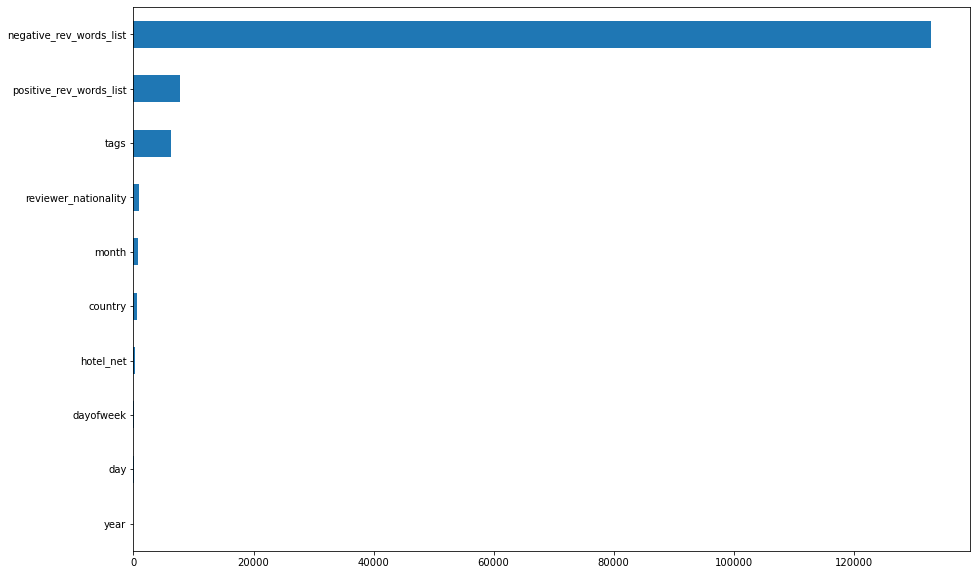

In [93]:
y=y.astype('int')

plt.rcParams['figure.figsize'] = (15,10)
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [94]:
# Отберем категориальные признаки, которые дают наибольший вклад:
res_cols = ['reviewer_score']
res_cols.extend(imp_cat[imp_cat >= 100].index)

<AxesSubplot:>

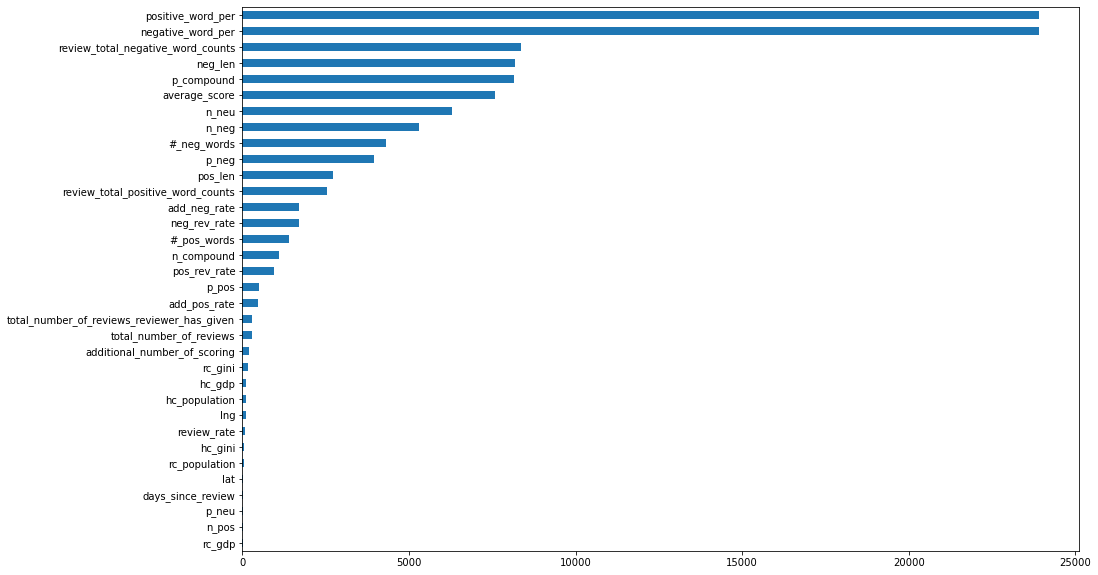

In [95]:
plt.rcParams['figure.figsize'] = (15,10)
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [96]:
# Отберем числовые признаки, которые дают наибольший вклад:
res_cols.extend(imp_num[imp_num > 100].index)

In [97]:
# Подготовим данные
train_data = train_data[res_cols]
res_cols.remove('reviewer_score')
test_data = test_data[res_cols]

## 4. Check the multicollinearity

<AxesSubplot:>

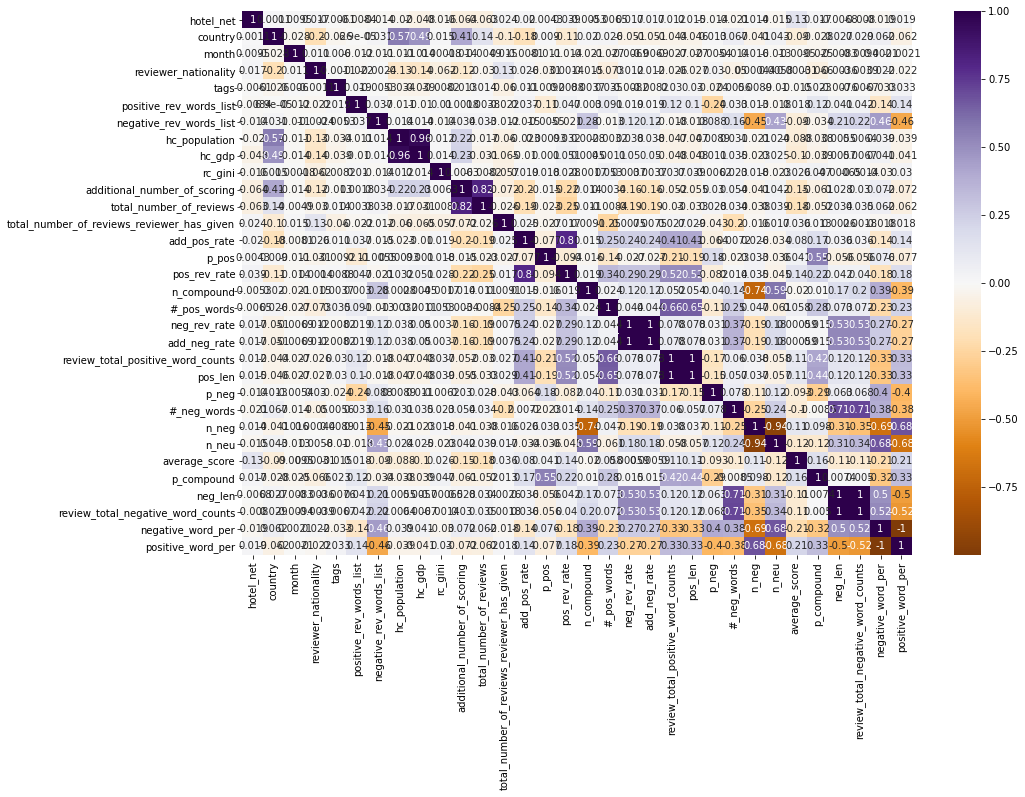

In [98]:
corr = train_data.drop('reviewer_score',axis=1).corr()
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(corr, annot=True, cmap='PuOr')

In [99]:
# Уберем признаки с мультикорреляцией
drop_col = ['hc_population','total_number_of_reviews','add_pos_rate','neg_rev_rate','review_total_positive_word_counts','n_neg','neg_len','positive_word_per']

train_data.drop(drop_col,axis=1,inplace=True)
test_data.drop(drop_col,axis=1,inplace=True)

<AxesSubplot:>

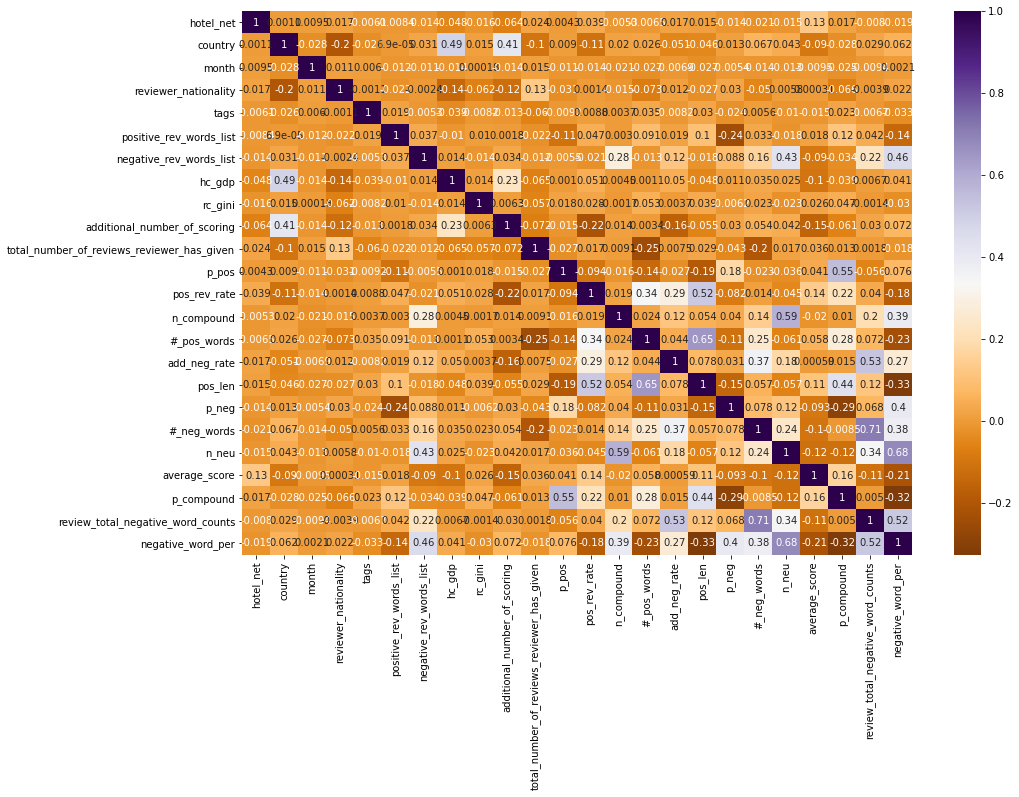

In [100]:
# Проверим оставшиеся признаки
corr = train_data.drop('reviewer_score',axis=1).corr() 
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(corr, annot=True, cmap='PuOr')

## 5. Model building

In [101]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = train_data.drop(['reviewer_score'], axis = 1)  
y = train_data['reviewer_score'] 

In [102]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

In [103]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=500, verbose=1, random_state=RANDOM_SEED, n_jobs=-1)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 14.5min finished


RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42, verbose=1)

## 6. Check results

In [104]:
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   52.1s finished


In [110]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
from sklearn import metrics
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

AttributeError: module 'sklearn.metrics' has no attribute 'mean_absolute_percentage_error'

## 7. Submission

In [106]:
test_pred = regr.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   24.4s


Prediction for te_data:
[8.6944 7.7828 7.9652 ... 8.1434 9.5044 7.5132]
Shape = (128935,)


[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   28.5s finished


In [108]:
submission = pd.read_csv(DATA_DIR + 'submission.csv')
print(submission.shape)
submission.head()

(128935, 2)


,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [109]:
submission['reviewer_score'] = test_pred.data
submission.to_csv(DATA_DIR + 'forest_rpedict_mape.csv', index = False)